# 1. Project Background

Today, burnout is often described as 'The Great Exhaustion' because according to a study published by Mercer in 2024, 8 out of 10 employees are at risk of burnout. It thus comes as no surprise that HR departments are very interested in monitoring their employees' burnout rate. Understanding and predicting employee burnout rates can provide organizations with the right insights to create supportive and healthy environments in the workplace.

This project aims to build a machine learning model to predict employee burnout rate from data such as gender, hours worked per day, designation, and the like.

# 2. Load Libraries & Data

In [1]:
# Impoting general libraries
import warnings
import itertools
import random

# Data Analysis Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as mn

# Data Preparation, Modeling, and Evaluation (SKLearn Modules)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler,RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split

# Class Imbalance
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from collections import Counter
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score,make_scorer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

# Machine Learning Models 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier

# Machine Learning Model Evaluation Methods 
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix

warnings.filterwarnings(action="ignore")
%matplotlib inline

In [2]:
#load train data set
train_df=pd.read_csv(r"C:\Users\User\Desktop\Zindua_Class_Data\Machine_Learning_Class1\Week5_CapstoneProject\dataset\train.csv")
train_df.head()

,Employee ID,Date of Joining,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
0,fffe32003000360033003200,2008-09-30,Female,Service,No,2.0,3.0,3.8,0.16
1,fffe3700360033003500,2008-11-30,Male,Service,Yes,1.0,2.0,5.0,0.36
2,fffe31003300320037003900,2008-03-10,Female,Product,Yes,2.0,NaN,5.8,0.49
3,fffe32003400380032003900,2008-11-03,Male,Service,Yes,1.0,1.0,2.6,0.20
4,fffe31003900340031003600,2008-07-24,Female,Service,No,3.0,7.0,6.9,0.52


# 3. EDA

### 3.1 Missingness

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22750 entries, 0 to 22749
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Employee ID           22750 non-null  object 
 1   Date of Joining       22750 non-null  object 
 2   Gender                22750 non-null  object 
 3   Company Type          22750 non-null  object 
 4   WFH Setup Available   22750 non-null  object 
 5   Designation           22750 non-null  float64
 6   Resource Allocation   21369 non-null  float64
 7   Mental Fatigue Score  20633 non-null  float64
 8   Burn Rate             21626 non-null  float64
dtypes: float64(4), object(5)
memory usage: 1.6+ MB


From this , we see that only 3 features including the target variable has missing values.

<Axes: >

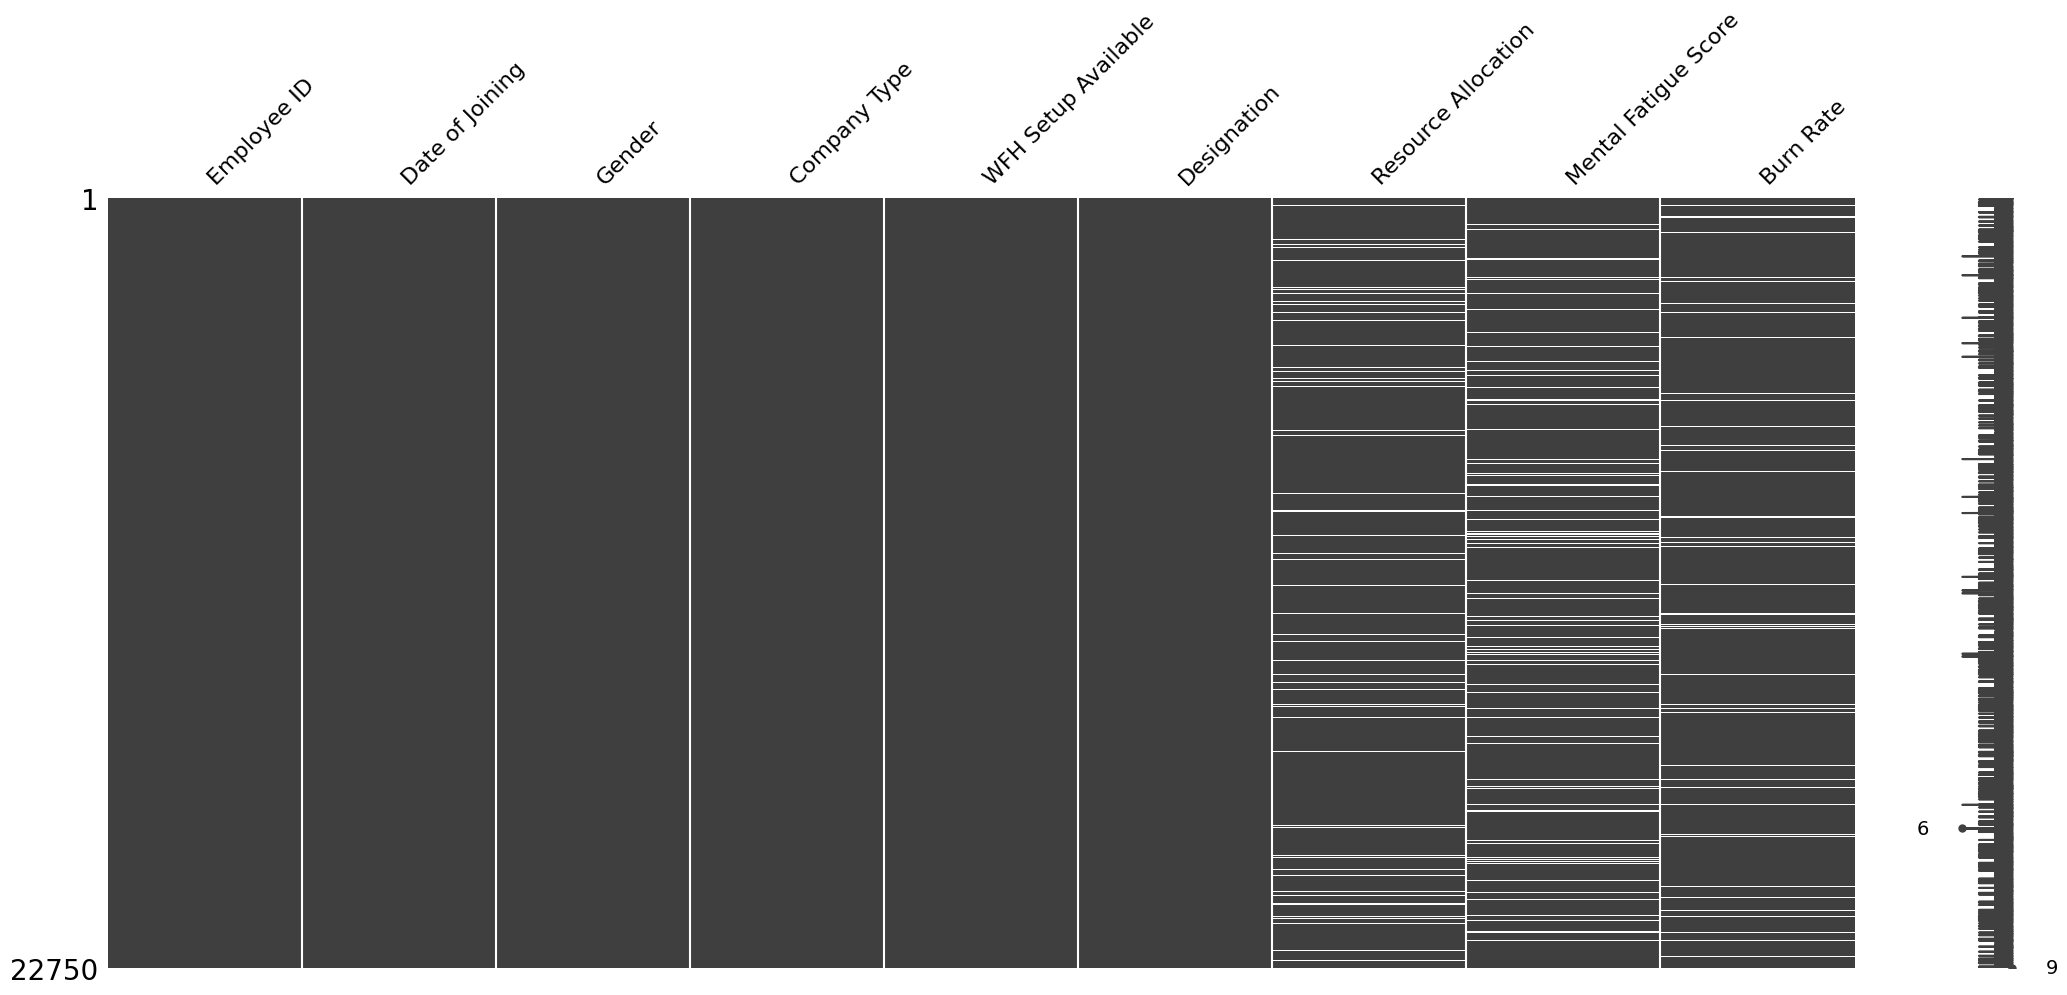

In [4]:
#plot matrix to visualize missingness
mn.matrix(train_df)

It is not advisable to impute rows with missing target variable, so drop all rows where the target variable is missing

<Axes: >

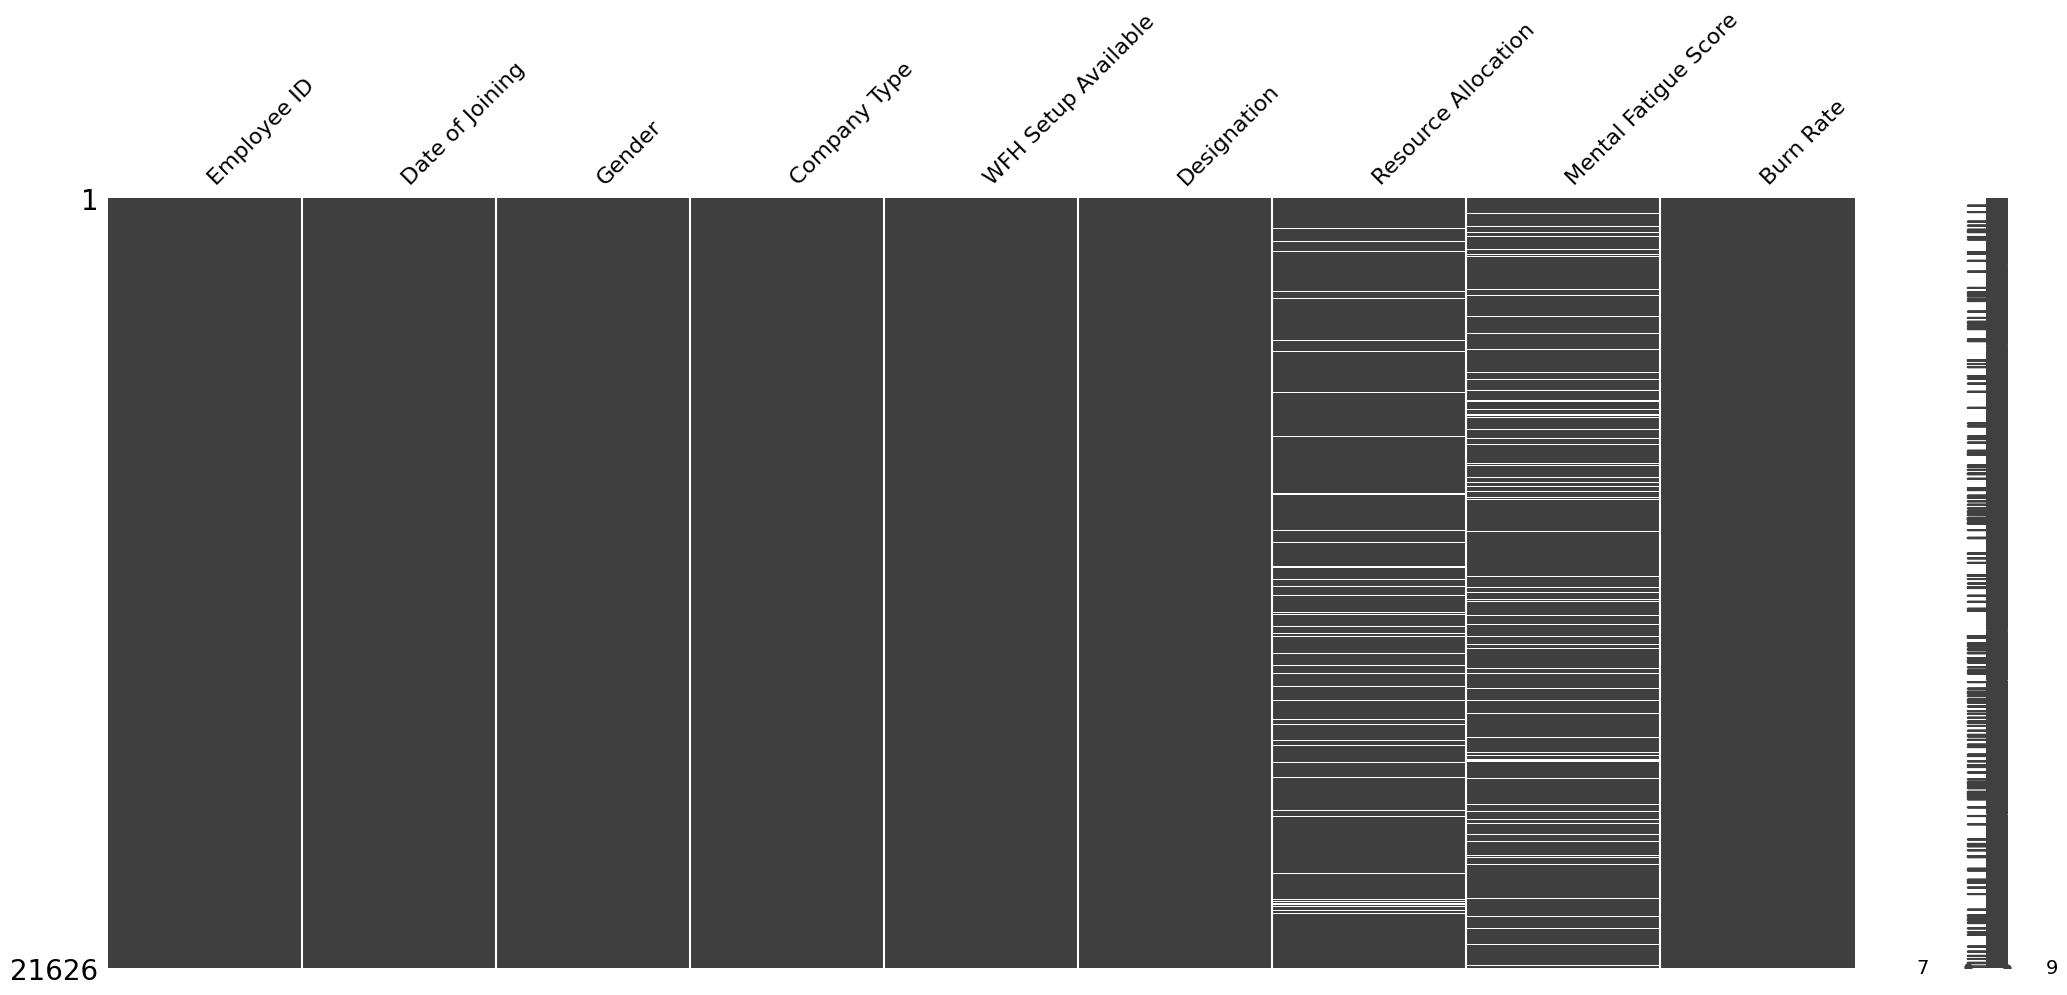

In [5]:
#drop null rows in the target column
train_df.dropna(subset=['Burn Rate'], inplace=True)
mn.matrix(train_df)

Now we need to calculate the proprotion of missingness in each column with missing values, in order to decide whether to drop or impute the data.

In [6]:
total_missing=train_df.isnull().sum().sort_values(ascending=False)
percent=train_df.isnull().sum().sort_values(ascending=False)/train_df.isnull().count().sort_values(ascending=False)
missing_df=pd.concat([total_missing,percent],axis=1,keys=['total_missing','percentage_missing'],sort=False)
missing_df.index.name='variable'# set the index name to variable 
missing_df=missing_df[total_missing>0] # only retain those with missing values 
missing_df['percentage_missing']=missing_df['percentage_missing'].map(lambda x:x*100) # convert to percentage 
missing_df

,total_missing,percentage_missing
variable,,
Mental Fatigue Score,1945,8.993804
Resource Allocation,1278,5.909553


Because each column has less very little missing values, we can proceed to impute values. To decide how to impute the values, we first explore the distribution of each variable with missing values.

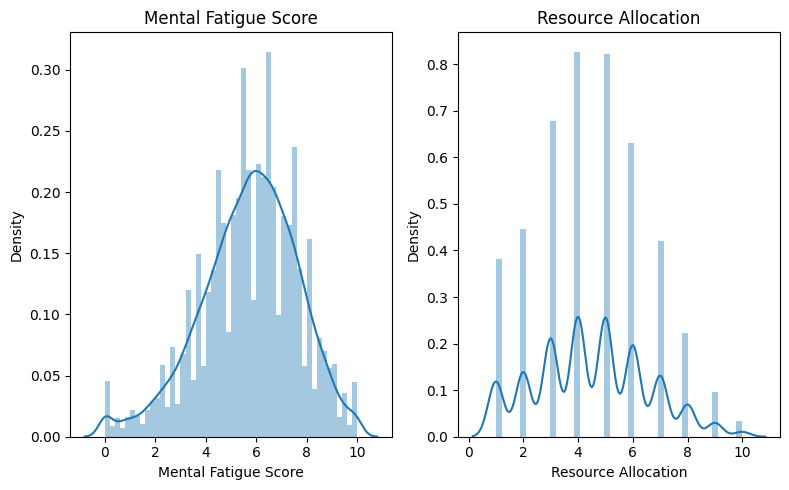

In [7]:
columns_to_plot=['Mental Fatigue Score','Resource Allocation']
fig = plt.figure(figsize=(8,5))
for i, column in enumerate(columns_to_plot):
    ax = fig.add_subplot(1, 2, i + 1)  
    sns.distplot(train_df[column],ax=ax)
    ax.set_title(column)
plt.tight_layout()
plt.show()

### Insights from distribution plots:
Mental Fatigue score has a normal distribution and therefore missing values can be imputed using mean.
Resource allocation has many peaks, therefore median imputation is best

In [8]:
#use fillna to impute
train_df['Mental Fatigue Score'].fillna(train_df['Mental Fatigue Score'].mean(),inplace=True)
train_df['Resource Allocation'].fillna(train_df['Resource Allocation'].median(),inplace=True)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21626 entries, 0 to 22749
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Employee ID           21626 non-null  object 
 1   Date of Joining       21626 non-null  object 
 2   Gender                21626 non-null  object 
 3   Company Type          21626 non-null  object 
 4   WFH Setup Available   21626 non-null  object 
 5   Designation           21626 non-null  float64
 6   Resource Allocation   21626 non-null  float64
 7   Mental Fatigue Score  21626 non-null  float64
 8   Burn Rate             21626 non-null  float64
dtypes: float64(4), object(5)
memory usage: 1.6+ MB


### 3.2 Outliers

In [9]:
#separte the dataframe into numerical and categorical data
num_df=train_df.select_dtypes(include=[np.number])
cat_df=train_df.select_dtypes(include=[object])

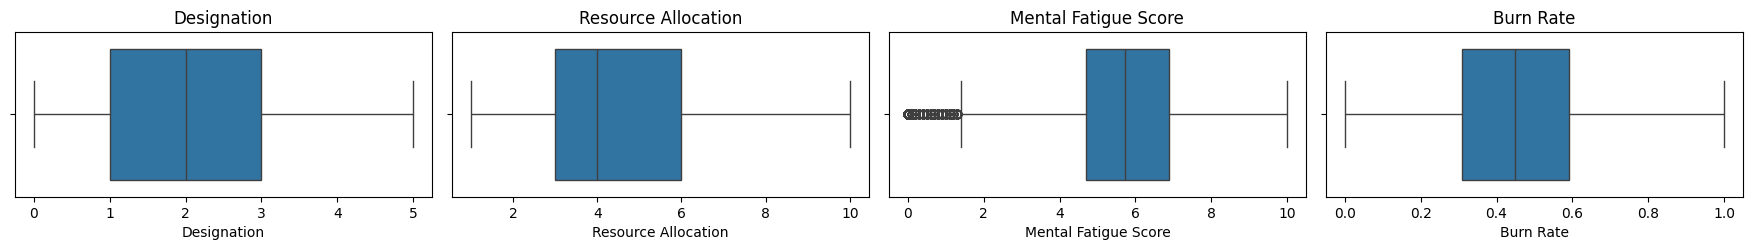

In [10]:
fig = plt.figure(figsize=(22,20))
for i in range(len(num_df.columns)):
    ax=fig.add_subplot(9, 5, i+1)
    sns.boxplot(x=num_df.iloc[:, i],ax=ax)
    ax.set_title(num_df.columns[i])
plt.tight_layout()
plt.show()

In [12]:
cat_df

Index(['Employee ID', 'Date of Joining', 'Gender', 'Company Type',
       'WFH Setup Available'],
      dtype='object')

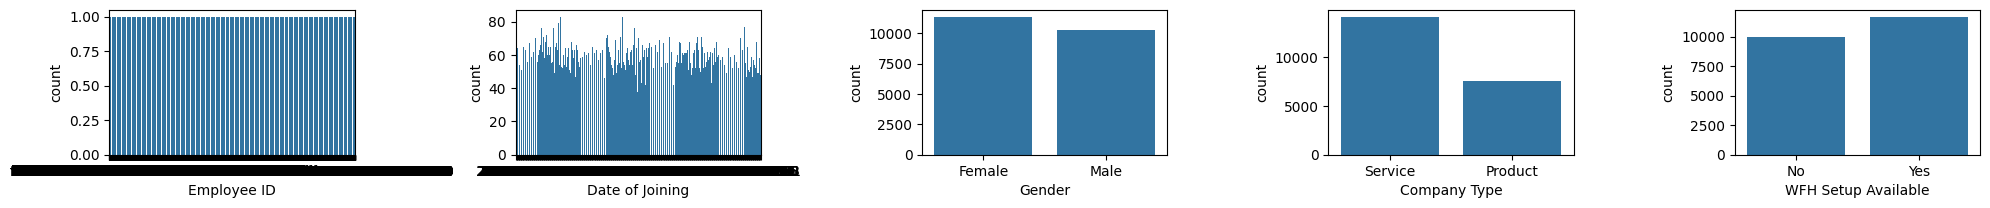

In [13]:
exclude_columns=['Employee ID','Date of Joining']
fig = plt.figure(figsize=(20,18))
for i in range(len(cat_df.columns)):
    if i not in exclude_columns:
        ax= fig.add_subplot(9, 5, i+1)
        sns.countplot(x=cat_df.iloc[:, i],ax=ax)
plt.tight_layout()
plt.show()

### 3.3 Correlation

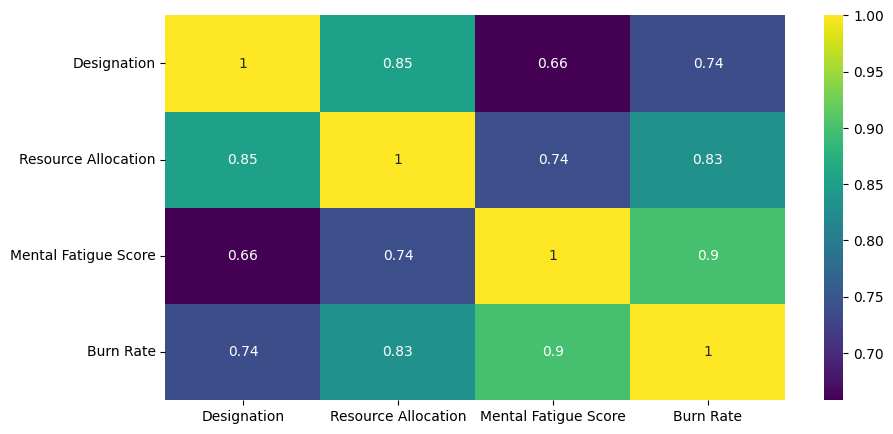

In [12]:
#correlation matrix
corrmat = num_df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(10,5))
g=sns.heatmap(num_df[top_corr_features].corr(),annot=True,cmap="viridis")

### 3.4 